# Building up the Problem - An Illustrations
Plot GATR vs other Benchmarks on an example three-agent-four-task problem for our five progressively complex problem types:
- Multiple Traveling Salesman Problem (mTSP)
- mTSP with multiple agent start locations
- mTSP with varying task time costs
- mTSP with both multiple start locations and varying task time costs
- mTSP with both multiple start locations and varying task time costs and agent cooperation (our full problem)

This notebook assumes that the following sets of experiments have already been collected (indicated by `Collected: {path}` below) using the scripts in `../run`. For instructions on how to run these scripts, please refer to `../example`. This notebook focuses solely on visualizing the results.

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import colormaps
import seaborn as sns
import ast

from graph_attention_replanner.config import (
    MissionPlanConfig,
    LogFileConfig
)
from graph_attention_replanner.method.gat import (
    get_gat_details,
)

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
palette = sns.color_palette()
problem_colour = palette
problem_colour_hex = palette.as_hex()
# https://www.fabiocrameri.ch/colourpalettes/
problem_colour_hex_next = [
    '#E7BBE3',  # Lighter, more distinct pink
    '#FF8C38',  # Brighter orange
    '#9FC537',  # Brighter, yellower green
    '#2F9DB2',  # Turquoise instead of forest green
    '#3B4992'   # Brighter navy blue
]
palette_next = sns.color_palette(problem_colour_hex)
os.system("mkdir -p ../../cache/plots")

0

In [7]:
method_presentable = {
    "gat": "GATR",
    "lkh": "NOpt-LKH3",
    "enum": "Opt-P",
    "median": "Med-P",
    "random": "Med-S",
}

method2charnum = {
    "gat": "A",
    "lkh": "C",
    "enum": "B",
    "median": "D",
    "random": "E",
}

problem_presentable = {
    1: "mTSP",
    2: "mTSP \n+ Task Time",
    3: "mTSP \n+ Start Loc.",
    4: "mTSP \n+ Start Loc.\n+ Task Time",
    5: "mTSP \n+ Start Loc.\n+ Task Time\n+ Collab",
}

method_details = {
    "gat": "gat_gpu_batch_exp100",
    "lkh": "lkh_gpu",
    "random": "random",
    "median": "median",
    "enum": "enum",
}

base_arg = {
    "mtsp_problem_type": 5,
    "num_agent": 3,
    "batch_size": 100,
}

dataset_4task_arg = {
    "num_task": 4,
    "num_node": 8,
    "discretize_level": 2,
}

datasets_arg = {
    "dataset_4task": dataset_4task_arg,
}

method_mtsp_problem_type = {
    "dataset_4task": [1, 2, 3, 4, 5],
}

method_seeds = {
    10: 0,
}

data_seed = 10

In [6]:
def remove_stem(path):
    parts = Path(path).parts
    idx = parts.index("cache")
    relative_path = Path(*parts[idx:]) 
    return relative_path

df_list = []
for dataset, dataset_arg in datasets_arg.items():
    for mtsp_problem_type in method_mtsp_problem_type[dataset]:
        for method in ["gat", "lkh", "enum", "median", "random"]:
            cfg = LogFileConfig(
                mtsp_problem_type,
                dataset_arg["num_node"],
                dataset_arg["num_task"],
                dataset_arg["num_task"],
                dataset_arg["discretize_level"],
                dataset_arg["discretize_level"],
                base_arg["num_agent"],
                base_arg["num_agent"],
                base_arg["batch_size"],
                read_only=True,
            )
            num_exp = 1 if (method == "gat" or method == "random") else 100
            method_seed = method_seeds[data_seed] if (method == "gat") else None
            path = cfg.get_result_logfilename(
                method=method_details[method],
                format="csv",
                num_exp=num_exp,
                seed = data_seed,
                method_seed = method_seed,
            )

            if os.path.exists(path):
                df = pd.read_csv(path)
                if method == "enum":
                    df.drop(columns=["all_mission_time"], inplace=True)
                df["method"] = method
                df["dataset"] = dataset
                # Special case for dataset_4task
                problem_num_node = dataset_arg["num_task"] if dataset == "dataset_4task" and mtsp_problem_type < 5 else dataset_arg["num_node"]
                df["num_node"] = problem_num_node
                df["discretize_level"] = dataset_arg["discretize_level"]
                df_list.append(df)
                print(f"Collected: {remove_stem(path)}")

            else:
                print(f"WARNING: File not found: {remove_stem(path)}")

MERGED_DF = pd.concat(df_list, ignore_index=True)

Collected: cache/results/gat_gpu_batch_exp100/problem1_node8_task4to4_dislevel2to2_agent3to3_bs100_exp1_dataseed10_methodseed0.csv
Collected: cache/results/lkh_gpu/problem1_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed10.csv
Collected: cache/results/enum/problem1_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed10.csv
Collected: cache/results/median/problem1_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed10.csv
Collected: cache/results/random/problem1_node8_task4to4_dislevel2to2_agent3to3_bs100_exp1_dataseed10.csv
Collected: cache/results/gat_gpu_batch_exp100/problem2_node8_task4to4_dislevel2to2_agent3to3_bs100_exp1_dataseed10_methodseed0.csv
Collected: cache/results/lkh_gpu/problem2_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed10.csv
Collected: cache/results/enum/problem2_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed10.csv
Collected: cache/results/median/problem2_node8_task4to4_dislevel2to2_agent3to3_bs100_exp100_dataseed

Set the experiment we would like to inspect

In [9]:
exp_idx = 27
SORTED_DF = MERGED_DF[MERGED_DF["exp_idx"] == exp_idx]
SORTED_DF.replace("median_tour", "median", inplace=True)

/var/folders/bl/91ns7my95h53vfz2h_xq62yh0000gs/T/ipykernel_82022/3144119605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SORTED_DF.replace("median_tour", "median", inplace=True)


In [10]:
args = MissionPlanConfig().parse_eval_args_notebook()
args.seed = data_seed
args.num_agent = 3
args.min_num_agent = 3
args.max_num_agent = 3
args.num_node = 8
args.num_task = 4
args.min_num_task = 4
args.max_num_task = 4
args.min_discretize_level = 2
args.max_discretize_level = 2
args.num_exp = 100
args.batch_size=100
args

def render(td, actions=None, ax=None, long_task=False, reward=None, mtsp_problem_type=5):
    start_locs_enabled = True if mtsp_problem_type in [3,4,5] else False
    task_lengths_enabled = True if mtsp_problem_type in [2,4,5] else False

    def discrete_cmap(num, base_cmap="nipy_spectral"):
        """Create an N-bin discrete colormap from the specified input map"""
        base = colormaps[base_cmap]
        color_list = base(np.linspace(0, 1, num))
        cmap_name = base.name + str(num)
        return base.from_list(cmap_name, color_list, num)

    if actions is None:
        actions = td.get("action", None)
    # if batch_size greater than 0 , we need to select the first batch element
    if td.batch_size != torch.Size([]):
        td = td[0]
        actions = actions[0]

    locs = td["locs"]
    if task_lengths_enabled:
        if mtsp_problem_type == 5:
            task_lengths = td["unsplited_task_length"]
        else:
            task_lengths = td["task_length"]
    if start_locs_enabled:
        start_locs = td["start_locs"]

    # fig, ax = plt.subplots()
    ax.set_xlim(-0.5, 10.5)
    ax.set_ylim(-0.5, 10.5)

    # Add depot action = 0 to before first action and after last action
    actions = torch.cat(
        [
            torch.zeros(1, dtype=torch.int64),
            actions,
            torch.zeros(1, dtype=torch.int64),
        ]
    )

    num_task = 4
    for i, loc in enumerate(locs):
        if i == 0:
            marker = "s"
            # color = "g"
            color = '#141414'
            label = "Depot"
            markersize = 8
        elif i <= num_task:
            # color = "tab:blue"
            color = '#141414'
            marker = "o"
            label = "Tasks"

            if task_lengths_enabled and task_lengths[i] > 0:
                # print("task_lengths[i]: ", task_lengths[i])
                markersize = 8*(1+task_lengths[i]/5)
            else:
                markersize = 8
        else:
            break
        ax.plot(
            loc[0],
            loc[1],
            color=color,
            marker=marker,
            markersize=markersize,
            label=label,
        )

    if start_locs_enabled:
        for i, loc in enumerate(start_locs):
            marker = "^"
            color = '#141414'
            label = "Start"
            markersize = 10
            ax.plot(
                loc[0],
                loc[1],
                color=color,
                marker=marker,
                markersize=markersize,
                label=label,
            )

    # Plot the actions in order
    agent_idx = 0
    for i in range(len(actions)):

        from_node = actions[i]
        from_loc = td["locs"][from_node]
        if actions[i] == 0:
            agent_idx += 1
        if start_locs_enabled and actions[i] == 0:
            # Skip plotting home base to start loc
            continue

        if i >= len(actions) - 1:
            break

        if actions[i] == 0 and i + 1 >= len(actions) - 1:
            # current node is end_tour, there is no more next node, i.e. agent has no tour
            to_node = actions[0]
        if actions[i + 1] == 0:
            # next node is end of tour, so we dont need to travel anymore
            to_node = actions[0]
        else:
            # next node is valid, so we go to it.
            to_node = actions[i + 1]

        to_loc = td["locs"][to_node]
        ax.plot([from_loc[0], to_loc[0]], [from_loc[1], to_loc[1]], color=problem_colour[agent_idx])
        ax.annotate(
            "",
            xy=(to_loc[0], to_loc[1]),
            xytext=(from_loc[0], from_loc[1]),
            arrowprops=dict(arrowstyle="->", color=problem_colour[agent_idx]),
            annotation_clip=False,
        )

    return ax

def remove_consecutive_zeros(arr):
    result = []
    zero_count = 0
    for num in arr:
        if num == 0:
            if zero_count == 0:
                result.append(0)
            zero_count += 1
        else:
            result.append(num)
            zero_count = 0    
    return result


def translate_tour(format, tour, mtsp_problem_type=5, num_node=8):
    num_node_incl_home = num_node+1
    if format == "median" or format == "enum":
        if format == "enum":
            enum_tour = np.array(tour[0]) # pick the first tour
        else:
            enum_tour = np.array(tour) # pick the tour
        num_agent = enum_tour.shape[0]
        tour = []

        if mtsp_problem_type in [1, 2]:
            for agent_idx, agent_tour in enumerate(enum_tour):
                non_zero = np.count_nonzero(agent_tour)
                agent_tour[agent_tour == 0] = 999 # replace 0 with 999
                # print(f"agent_tour: {agent_tour}")
                at = np.argsort(agent_tour) + 1 # add 1 because 0 is depot
                at = at[:non_zero]
                tour.extend(list(at))
                if agent_idx < num_agent - 1: # last agent dont append 0.
                    tour.append(0)
        elif mtsp_problem_type in [3, 4, 5]:
            start_loc_node = list(np.arange(num_node_incl_home, num_node_incl_home+num_agent))
            # print(f"enum_tour: {enum_tour}")
            for agent_idx, agent_tour in enumerate(enum_tour):
                tour.append(start_loc_node[agent_idx])
                non_zero = np.count_nonzero(agent_tour)
                agent_tour[agent_tour == 0] = 999 # replace 0 with 999
                # print(f"agent_tour: {agent_tour}")
                at = np.argsort(agent_tour) + 1 # add 1 because 0 is depot
                at = at[:non_zero]
                tour.extend(list(at))
                if agent_idx < num_agent - 1: # last agent dont append 0.
                    tour.append(0)
    elif format == "lkh":
        num_agent = len(tour)
        lkh_tour = copy.deepcopy(tour)

        if mtsp_problem_type in [3, 4, 5]:
            # virtual home 0, home 1 to 1+num_agent, start_loc 2 to 2+num_agent, subtask
            num_task = 4
            discretize_level = int(num_node/num_task)
            lkh2gat = [None] # virtual home 0
            lkh2gat.extend([0]*num_agent) 
            for i in range(num_agent):
                lkh2gat.extend([num_node_incl_home+i])
            for i in range(discretize_level):
                lkh2gat.extend(list(np.arange(1, num_task+1)))
            # print(lkh2gat)
            tour = []
            for agent_idx, agent_tour in enumerate(lkh_tour):
                agent_tour = [lkh2gat[i] for i in agent_tour]
                tour.extend(agent_tour)
                if agent_idx < num_agent - 1:
                    tour.append(0)
            # Remove None
            tour = [x for x in tour if x is not None]
            tour = remove_consecutive_zeros(tour)
            tour = tour[:-1] # remove ending zero

        if mtsp_problem_type in [1, 2]:
            num_task = 4
            discretize_level = int(num_node/num_task)
            lkh2gat = [0] # home 0
            for i in range(discretize_level):
                lkh2gat.extend(list(np.arange(1, num_task+1)))
            tour = []
            for agent_idx, agent_tour in enumerate(lkh_tour):
                if mtsp_problem_type == 1:
                    agent_tour = [x-1 for x in agent_tour]
                agent_tour = [lkh2gat[i] for i in agent_tour]
                tour.extend(agent_tour)
                if agent_idx < num_agent - 1:
                    tour.append(0)
            tour = remove_consecutive_zeros(tour)
            tour = tour[1:-1] # remove leading and ending zero

    return torch.tensor(tour, dtype=torch.int64)

def normalize_tour(tour):
    """
    Normalize a tour so that it starts with the smallest non-delimiter (non-zero) value.
    
    Args:
        tour (list): The tour as a list of integers, with 0 as the delimiter.
    
    Returns:
        list: The normalized tour.
    """
    # Split the tour into subtours based on the delimiter (0)
    subtours = []
    current_subtour = []
    for node in tour:
        if node == 0:
            if current_subtour:
                subtours.append(current_subtour)
                current_subtour = []
        else:
            current_subtour.append(node)
    if current_subtour:  # Append the last subtour if any
        subtours.append(current_subtour)
    
    # Find the subtour with the smallest starting point
    sorted_subtours = sorted(subtours, key=lambda x: (x[0], x))
    
    # Rebuild the tour starting with the smallest subtour
    normalized_tour = []
    for subtour in sorted_subtours:
        normalized_tour.extend(subtour + [0])
    
    # Remove the trailing delimiter
    if normalized_tour[-1] == 0:
        normalized_tour.pop()

    return torch.tensor(normalized_tour)

/Users/ekwan/graph-attention-replanner/.venv/lib/python3.10/site-packages/torchrl/data/tensor_specs.py:6911: DeprecationWarning: The BoundedTensorSpec has been deprecated and will be removed in v0.8. Please use Bounded instead.
  warnings.warn(
/Users/ekwan/graph-attention-replanner/.venv/lib/python3.10/site-packages/torchrl/data/tensor_specs.py:6911: DeprecationWarning: The UnboundedDiscreteTensorSpec has been deprecated and will be removed in v0.8. Please use Unbounded instead.
  warnings.warn(
/Users/ekwan/graph-attention-replanner/.venv/lib/python3.10/site-packages/torchrl/data/tensor_specs.py:6911: DeprecationWarning: The UnboundedContinuousTensorSpec has been deprecated and will be removed in v0.8. Please use Unbounded instead.
  warnings.warn(
/Users/ekwan/graph-attention-replanner/.venv/lib/python3.10/site-packages/torchrl/data/tensor_specs.py:6911: DeprecationWarning: The CompositeSpec has been deprecated and will be removed in v0.8. Please use Composite instead.
  warnings.wa

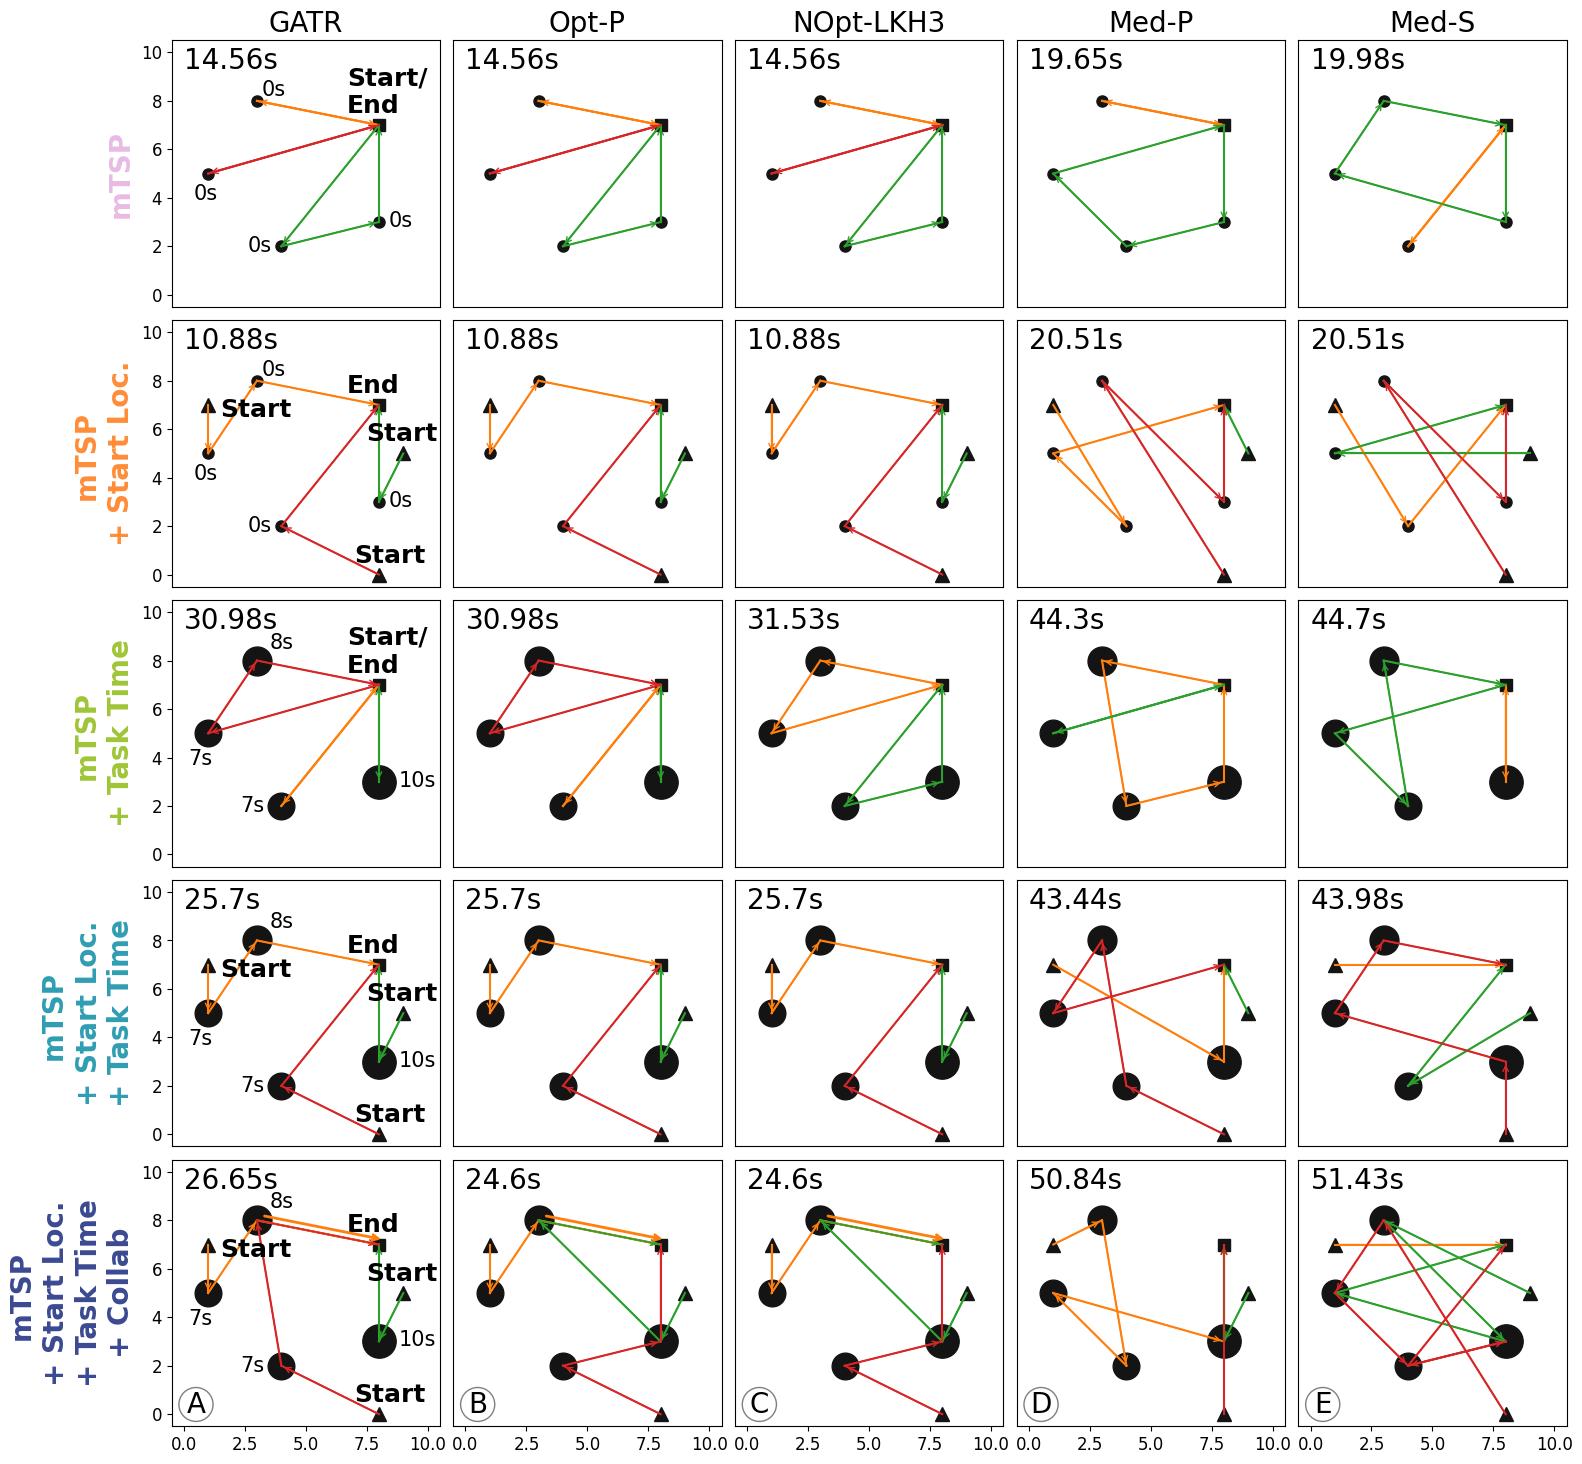

In [11]:
fig, axis = plt.subplots(5, 5, figsize=(18, 18))

all_actions = [dict() for i in range(5)]
all_mission_times = [dict() for i in range(5)]
for problem_idx, mtsp_problem_type in enumerate([1,3,2,4,5]):
    args.method_mtsp_problem_type=mtsp_problem_type
    actions = all_actions[problem_idx]
    mission_times = all_mission_times[problem_idx]
    for method_idx, method in enumerate(["gat", "enum", "lkh", "random", "median"]):
        df = SORTED_DF[(SORTED_DF["method"] == method) & (SORTED_DF["mtsp_problem_type"] == args.method_mtsp_problem_type)]
        
        actions[method] = ast.literal_eval(df["tour"].values[0])
        mission_times[method] = df["mission_time"].values
        t = np.round(mission_times[method][0],2)
        num_node = df["num_node"].values[0]
        action = translate_tour(method, actions[method], mtsp_problem_type=mtsp_problem_type, num_node=num_node)
        actions[method] = normalize_tour(action)

# Tidy up similar tour here, special case here
all_actions[2]["enum"] = all_actions[2]["gat"]
all_actions[3]["enum"] = all_actions[3]["lkh"]
all_actions[4]["enum"] = all_actions[4]["lkh"]

def add_circle(ax_local, character):
    circle = plt.Circle((0.5, 0.4), 0.7, color='grey', fill=False)  # (x, y), radius, color
    ax_local.add_artist(circle)
    ax_local.text(0.5, 0.4, character, color='black', fontsize=20, ha='center', va='center')  # ha/va = horizontal/vertical alignment


label_font_size = 20
for problem_idx, mtsp_problem_type in enumerate([1,3,2,4,5]):
    args.method_mtsp_problem_type=mtsp_problem_type
    env, td = get_gat_details(args)
    for method_idx, method in enumerate(["gat", "enum", "lkh", "median", "random"]):

        if method_idx == 0:
            axis[problem_idx][method_idx].set_ylabel(f"{problem_presentable[mtsp_problem_type]}", fontsize=label_font_size, color = problem_colour_hex_next[problem_idx], weight='bold')
        if problem_idx == 0:
            axis[problem_idx][method_idx].set_title(f"{method_presentable[method]}", fontsize=label_font_size)
        if problem_idx == 4:
            add_circle(axis[problem_idx][method_idx], method2charnum[method])
        t = np.round(all_mission_times[problem_idx][method][0],2)
        axis[problem_idx][method_idx].text(x=0,y=9.3, s=f"{t}s", fontsize=label_font_size)
        render(td.cpu().detach()[exp_idx], all_actions[problem_idx][method], reward=all_mission_times[problem_idx][method], ax=axis[problem_idx][method_idx], mtsp_problem_type=mtsp_problem_type)

# Remove all ticks
nrows, ncols = 5, 5
for i, ax in enumerate(axis.flat):
    # Get row and column index
    row, col = divmod(i, ncols)
    # Remove ticks and labels for non-boundary axes
    if row != nrows - 1:  # Not bottom row
        ax.tick_params(labelbottom=False, bottom=False, labelsize=12)
    if col != 0:  # Not left column
        ax.tick_params(labelleft=False, left=False, labelsize=12)
    if row != 0:  # Not top row
        ax.tick_params(labeltop=False, top=False, labelsize=12)
    if col != ncols - 1:  # Not right column
        ax.tick_params(labelright=False, right=False, labelsize=12)

# Manual overlay
font_size = 18
font_size_task = 15
axis[0][0].text(6.7, 7.5, "Start/\nEnd", fontsize=font_size, weight='bold')
axis[1][0].text(6.7, 7.5, "End", fontsize=font_size, weight='bold')
axis[2][0].text(6.7, 7.5, "Start/\nEnd", fontsize=font_size, weight='bold')
axis[3][0].text(6.7, 7.5, "End", fontsize=font_size, weight='bold')
axis[4][0].text(6.7, 7.5, "End", fontsize=font_size, weight='bold')

for problem_idx in [0,1]:
    axis[problem_idx][0].text(0.4, 3.9, "0s", fontsize=font_size_task)
    axis[problem_idx][0].text(3.2, 8.2, "0s", fontsize=font_size_task)
    axis[problem_idx][0].text(2.6, 1.75, "0s", fontsize=font_size_task)
    axis[problem_idx][0].text(8.4, 2.8, "0s", fontsize=font_size_task)
for problem_idx in [2,3,4]:
    axis[problem_idx][0].text(0.2, 3.7, "7s", fontsize=font_size_task)
    axis[problem_idx][0].text(3.5, 8.5, "8s", fontsize=font_size_task)
    axis[problem_idx][0].text(2.3, 1.75, "7s", fontsize=font_size_task)
    axis[problem_idx][0].text(8.8, 2.8, "10s", fontsize=font_size_task)

for problem_idx in [1,3,4]:
    axis[problem_idx][0].text(1.5, 6.5, "Start", fontsize=font_size, weight='bold')
    axis[problem_idx][0].text(7.5, 5.5, "Start", fontsize=font_size, weight='bold')
    axis[problem_idx][0].text(7, 0.5, "Start", fontsize=font_size, weight='bold')


for method_idx in [0,1,2]:
    axis[4][method_idx].annotate(
        "",
        xy=(8.2, 7.2),
        xytext=(3.2, 8.2),
        arrowprops=dict(arrowstyle="->", color=problem_colour[1], lw=2),
        annotation_clip=False,
    )

fig.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig("../../cache/plots/results_illustration.pdf", bbox_inches='tight')